In [1]:
## notebook for coherence and using bigrams

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import datetime
print(datetime.datetime.now())

2024-07-15 19:22:30.460402


In [3]:
import spacy
import nltk
import re
import string
import pandas as pd
import numpy as np

import gensim
from gensim import corpora
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import json
%matplotlib inline

In [4]:
#HANDELING STOPWORDS#
#NLTK
from nltk.corpus import stopwords

nltk.download("stopwords")
stopwords = stopwords.words("english")
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     D:\Users\isabelmetzger\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
pulse= pd.read_csv("NLPPulseData.csv")
print(type(pulse))

print(pulse.shape[0])
DF = pulse.iloc[1:,:]
DF2 = DF.iloc[1:,:]
DF_TEXT_ONLY = DF2[DF2["Q12"].notna()]

# amount of pulse survey responses with a free text comment
print(DF_TEXT_ONLY.shape[0])

<class 'pandas.core.frame.DataFrame'>
4142
1274


In [6]:
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [7]:
stop_word_list = stopwords # + add additional stopwords

In [8]:
#IMPORT TQDM FOR RUNNING PROGRESS#
from tqdm import tqdm

In [9]:



nlp = spacy.load('en_core_web_sm')
STOPWORDS_DICT = {lang: set(nltk.corpus.stopwords.words(lang)) for lang in nltk.corpus.stopwords.fileids()}


def clean_all(df, col_name):
    """
    Combines all functions used to clean and lemmatize the comments.
    :param df: data frame with comments
    :param col_name: column name in data frame containing comments
    :return: data frame with comments column lemmatized
    """

    # encode for only ascii characters
    df[col_name] = df[col_name].map(ascii_rm)
    
    # lowercase texts
    df[col_name] = df[col_name].map(lambda x: x.lower())


    # lemmatize words
    df[col_name] = df[col_name].astype(str).map(lemma)

    # remove punctuation
    df[col_name] = df[col_name].map(punc_n)


    # filter only english comments/non blank comments
    df['language'] = df[col_name].map(get_language)
    df = df.loc[df['language'] == 'english']
    df = df.drop('language', axis=1)
    df = df[df[col_name] != ""]
    
    return df


def ascii_rm(comment):
    """
    Parses comments and keep only ascii characters
    :param comment: a comment
    :return: comment with only ascii characters
    """
    comment = comment.encode('ascii', errors = 'ignore')
    return comment

def get_language(text):
    """
    Determines what language the comment is written in and filters only English comments.
    :param text: comment
    :return: language of comment
    """
    words = set(nltk.wordpunct_tokenize(text.lower()))
    return max(((lang, len(words & stopwords)) for lang, stopwords in STOPWORDS_DICT.items()), key = lambda x: x[1])[0]


def punc_n(comment):
    """
    Removes punctuations from comments.
    :param comment: a comment
    :return: comment without punctuations
    """
    regex = re.compile('[' + re.escape('!"#%&\'()*+,-./:;<=>?@[\\]^_`{|}~')+'0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", comment)
    nopunct_words = nopunct.split(' ')
    filter_words = [word.strip() for word in nopunct_words if word != '']
    words = ' '.join(filter_words)
    return words



def lemma(comment):
    """
    Lemmatize comments using spacy lemmatizer.
    :param comment: a comment
    :return: lemmatized comment
    """
    lemmatized = nlp(comment)
    lemmatized_final = ' '.join([word.lemma_ for word in lemmatized if word.lemma_ != '\'s'])
    return lemmatized_final

In [10]:
comments = clean_all(DF_TEXT_ONLY, "Q12")





D:\Users\isabelmetzger\AppData\Local\Temp\1\ipykernel_16288\443923628.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = df[col_name].map(ascii_rm)
D:\Users\isabelmetzger\AppData\Local\Temp\1\ipykernel_16288\443923628.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = df[col_name].map(lambda x: x.lower())
D:\Users\isabelmetzger\AppData\Local\Temp\1\ipykernel_16288\443923628.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [11]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in DF_TEXT_ONLY.Q12])
# Filter only those that occur at least 40 )N times
n = 40
finder.apply_freq_filter(n)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

In [12]:
bigram_scores

[(('pay', 'period'), 9.229269489458371),
 (('life', 'balance'), 8.608460187820377),
 (('fully', 'remote'), 7.39855559926813),
 (('go', 'into'), 6.862505810426914),
 (('come', 'into'), 6.854093570610713),
 (('full', 'time'), 6.843167510564927),
 (('day', 'per'), 6.48553635198159),
 (('on', 'site'), 6.428440550696779),
 (('from', 'home'), 6.361227638109476),
 (('more', 'productive'), 6.2363332132977085),
 (('at', 'home'), 5.710828602467977),
 (('in', 'person'), 5.440409822157239),
 (('do', 'not'), 5.262028535560567),
 (('hybrid', 'environment'), 5.175153443726696),
 (('work', 'life'), 5.141964800746688),
 (('I', 'believe'), 4.857772674186194),
 (('work', 'environment'), 4.7823649820865946),
 (('hybrid', 'work'), 4.768072612868906),
 (('a', 'week'), 4.663259090223349),
 (('I', 'think'), 4.648458255752292),
 (('able', 'to'), 4.516877880060633),
 (('due', 'to'), 4.456756887623062),
 (('my', 'job'), 4.447885665472057),
 (('my', 'team'), 4.4098066627515635),
 (('the', 'same'), 4.3765776900947

In [13]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([comment.split() for comment in DF_TEXT_ONLY.Q12])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(n)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)

In [14]:
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [15]:
bigram_pmi.head(20)

,bigram,pmi
0,"(pay, period)",9.229269
1,"(life, balance)",8.608460
2,"(fully, remote)",7.398556
3,"(go, into)",6.862506
4,"(come, into)",6.854094
5,"(full, time)",6.843168
6,"(day, per)",6.485536
7,"(on, site)",6.428441
8,"(from, home)",6.361228
9,"(more, productive)",6.236333


In [16]:
trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [17]:
# Filter for bigrams with only noun-type structures
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stop_word_list or bigram[1] in stop_word_list:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True

In [18]:
# Filter for trigrams with only noun-type structures
def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if trigram[0] in stop_word_list or trigram[-1] in stop_word_list or trigram[1] in stop_word_list:
        return False
    if 'n' in trigram or 't' in trigram:
         return False
    if 'PRON' in trigram:
        return False
    return True 

In [19]:
threshold = 3
# Can set pmi threshold to whatever makes sense - eyeball through and select threshold where n-grams stop making sense
# choose top 500 ngrams in this case ranked by PMI that have noun like structures
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                              bigram_filter(bigram['bigram'])\
                                              and bigram.pmi > threshold, axis = 1)][:500]

filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram: \
                                                 trigram_filter(trigram['trigram'])\
                                                 and trigram.pmi > threshold, axis = 1)][:500]


bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

In [20]:
bigrams

['pay period',
 'life balance',
 'full time',
 'day per',
 'hybrid environment',
 'work life',
 'work environment',
 'hybrid work',
 'remote work']

In [21]:
# examples of trigrams
trigrams[:10]


['work life balance', 'hybrid work environment']

In [22]:

def replace_ngram(x):
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

In [23]:
trigrams

['work life balance', 'hybrid work environment']

In [24]:
comments_w_ngrams = comments.copy()
comments_w_ngrams.Q12 = comments.Q12.map(lambda x: replace_ngram(x))
comments_w_ngrams = comments_w_ngrams.Q12.map(str).map(lambda x: [word for word in x.split()
                                                 if word not in stop_word_list
                                                              and len(word) > 2])
comments_w_ngrams.head()

52    [love, telework, experience, wish, continue, u...
58                                [stop, micromanaging]
64                       [additional, information, add]
65                [hybrid, schedule, reason, join, gsa]
93         [eem, continue, bandwidth, issue, teleworke]
Name: Q12, dtype: object

In [25]:
# Filter for only nouns
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

final_comments = comments_w_ngrams.map(noun_only)

In [26]:
# recommend tryingwith comments with ngrams and not just finakl comments
dictionary = corpora.Dictionary(final_comments) # try swapping out with comments w n grams
doc_term_matrix = [dictionary.doc2bow(doc) for doc in final_comments] # try swapping out w comments w n grams

In [27]:
# optimize # of k topics
coherence = []
for k in range(5,25):
    print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary, passes=40,\
                   iterations=200, chunksize = 10000, eval_every = None)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=final_comments,\
                                                     dictionary=dictionary, coherence='c_v')
    coherence.append((k,cm.get_coherence()))

Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19
Round: 20
Round: 21
Round: 22
Round: 23
Round: 24


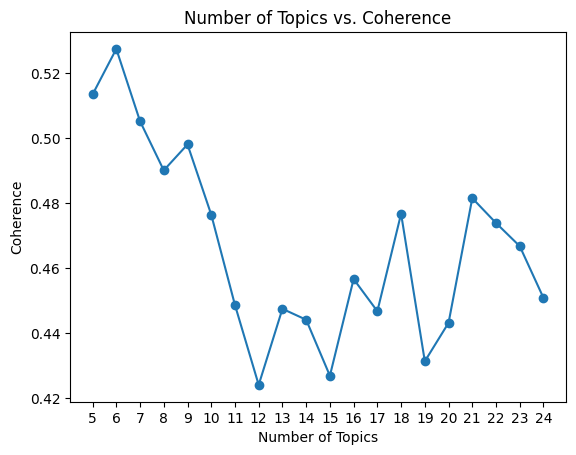

In [28]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]


## plotting 
plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

In [29]:
# Coherence drops after 6 so lets try with 6

In [30]:
final_comments

52          [telework, experience, continue, uninterupte]
58                                  [stop, micromanaging]
64                                     [information, add]
65                          [schedule, reason, join, gsa]
93                                [eem, issue, teleworke]
                              ...                        
3562    [research, show, remote_work, arrangement, inc...
3566                     [application, report, job, site]
3580                         [concern, technology, event]
3584    [schedule, group, colleague, build, relationship]
4122                                 [holiday, gathering]
Name: Q12, Length: 169, dtype: object

The improvement stops to significantly improve after 5 topics. It is not always where the highest Cv is, so we can try a couple to see which has the best result. We'll try 6, 15, and 23 here. Adding topics can help reveal further sub topics. Nonetheless, if the same words start to appear across multiple topics, the number of topics is too high.

In [31]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=9, id2word = dictionary, passes=40,\
               iterations=200,  chunksize = 10000, eval_every = None, random_state=0)


Lda2 = gensim.models.ldamodel.LdaModel
ldamodel2 = Lda2(doc_term_matrix, num_topics=23, id2word = dictionary, passes=40,\
               iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

In [32]:
# To show initial topics
ldamodel.show_topics(9, num_words=10, formatted=False)

[(0,
  [('telework', 0.09640326),
   ('option', 0.0415181),
   ('ability', 0.041513797),
   ('continue', 0.025270367),
   ('staff', 0.02526888),
   ('position', 0.025265617),
   ('offer', 0.01714788),
   ('work', 0.0171468),
   ('impact', 0.017146751),
   ('mission', 0.017146723)]),
 (1,
  [('office', 0.04151792),
   ('employee', 0.04151754),
   ('productivity', 0.03225402),
   ('gsa', 0.02527169),
   ('mission', 0.025271606),
   ('connection', 0.025271168),
   ('monitor', 0.017149532),
   ('team', 0.017148891),
   ('internet', 0.017148603),
   ('increase', 0.017148575)]),
 (2,
  [('work', 0.05735744),
   ('telework', 0.04472451),
   ('requirement', 0.043205816),
   ('site', 0.029066006),
   ('team', 0.021997187),
   ('flexibility', 0.014929676),
   ('position', 0.014928525),
   ('environment', 0.014926178),
   ('hybrid_work', 0.014926022),
   ('manage', 0.014925892)]),
 (3,
  [('management', 0.027338374),
   ('software', 0.027338075),
   ('continue', 0.014389062),
   ('productivity', 

In [33]:
trigrams

['work life balance', 'hybrid work environment']

In [34]:
# To show initial topics
ldamodel2.show_topics(23, num_words=10, formatted=False)

[(0,
  [('continue', 0.073219545),
   ('office', 0.04916356),
   ('offer', 0.04916333),
   ('require', 0.049163),
   ('expand', 0.049160175),
   ('telework', 0.025104882),
   ('region', 0.02510466),
   ('presence', 0.02510466),
   ('commute', 0.02510466),
   ('job', 0.02510466)]),
 (1,
  [('telework', 0.052985843),
   ('money', 0.027056467),
   ('increase', 0.027056467),
   ('productivity', 0.027056467),
   ('prefer', 0.027056467),
   ('taxpayer', 0.027056467),
   ('access', 0.027056457),
   ('meet', 0.027056457),
   ('tool', 0.027056457),
   ('homekit', 0.027056457)]),
 (2,
  [('telework', 0.33199626),
   ('full_time', 0.09149285),
   ('option', 0.09145926),
   ('implement', 0.02361151),
   ('office', 0.02361151),
   ('optional', 0.02361151),
   ('attendance', 0.02361151),
   ('transparency', 0.023611471),
   ('townhall', 0.023611471),
   ('comment', 0.023611471)]),
 (3,
  [('hybrid_work_environment', 0.16573092),
   ('offer', 0.09561825),
   ('support', 0.06714967),
   ('appreciate',

In [35]:
import pyLDAvis
topic_data =  pyLDAvis.gensim.prepare(ldamodel2, doc_term_matrix, dictionary, mds = 'pcoa')
#pyLDAvis.display(topic_data) ## cant get this to display -- 


In [36]:
# topic_data

In [37]:
all_topics = {}
num_terms = 12 # Adjust number of words to represent each topic
lambd = 0.6 # Adjust this accordingly based on tuning above
for i in range(1,9): #Adjust this to reflect number of topics chosen for final LDA model
    topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values




In [38]:
df_topics = pd.DataFrame(all_topics).T
df_topics

,0,1,2,3,4,5,6,7,8,9,10,11
Topic 1,work,software,hybrid,deliver,site,workforce,requirement,flexibility,option,edit,milestone,mobile
Topic 2,time,job,suggestion,love,hybrid_work_environment,gsa,work,support,afford,serve,bearer,standard
Topic 3,position,impact,energy,telework,environment,continue,rto,regressive,eliminate,carbon,micromanaging,partake
Topic 4,productivity,increase,station,area,duty,report,office,record,confirm,basis,accountability,sale
Topic 5,work,gsa,change,place,ability,reason,flexibility,career,life,cease,join,hour
Topic 6,connection,internet,employee,benefit,person,mission,office,service,communication,platform,share,eem
Topic 7,remote_work,site,responsibility,category,value,manage,requirement,improve,initiative,inspection,limit,vehicle
Topic 8,office,work_environment,home,distraction,concern,day,requirement,satisfaction,camaraderie,lack,setup,gathering


In [39]:
print(datetime.datetime.now())

2024-07-15 19:27:54.366480
